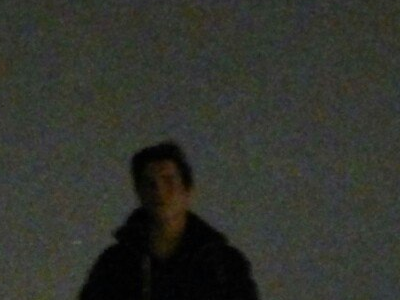

In [45]:
from PIL import Image
import numpy as np
import cv2

img_original = np.array(Image.open('test.jpg'))
img_original = img_original[300:600, 800:1200]
Image.fromarray(img_original)

## Простая сортировка

Для каждого пикселя (всего ${H W}$) из исходного изображения выделяем окно размером ${(2R+1)\times(2R+1)}$. У пикселей в окне находим медианные значения по каждому из каналов - это и есть искомый цвет. Сортировка займет ${O(n\log{n})}$ для $n = O(R^2)$.

Сложность - ${O(R^2\log{R} \times (H W))}$. Можно использовать сортировку с подсчетом, тогда сложность будет - ${O(R^2 \times (H W))}$.

Доп. память - ${O(R^2 + (H W))}$.

In [32]:
def naive_sort(input_img, R):
    bordered_img = cv2.copyMakeBorder(input_img, R, R, R, R, cv2.BORDER_REPLICATE)
    output_img = np.zeros_like(input_img)
    mid = (2 * R + 1) ** 2 // 2
    for i in range(input_img.shape[0]):
        for j in range(input_img.shape[1]):
            output_img[i][j] = np.sort(
                bordered_img[i:i + 2 * R + 1,j:j + 2 * R + 1]
                .reshape(-1,3),axis=0)[mid]
            
    return output_img      

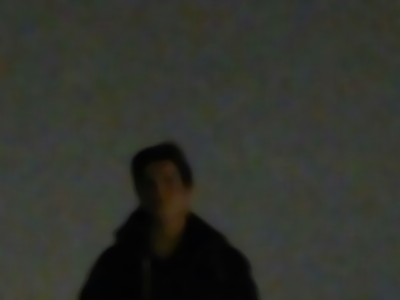

In [33]:
naive_sorted = naive_sort(img_original, 5)
Image.fromarray(naive_sorted)

## Алгоритм Huang et al.

Будем хранить гистограмму окна размером ${(2R+1)\times(2R+1)}$ при проходе по строке. При смещении окна происходит ${2 (2R + 1)}$ обращений к гистограмме, т. е. сложность будет ${O(R)}$. Медиана высчитывается за ${O(N)}$. Инициализация гистограммы имеет сложность ${O(R^2)}$.
Тогда сложность будет ${O(H (R^2 + W (R + N)))}$.

Так как ${W > R}$, то конечная сложность составит ${O((R + N) \times (H W))}$.

Доп. память - ${O(N + (H W))}$.

In [34]:
class Hist:
    def __init__(self, init_array, R):
        self.R = R
        self.hist = np.zeros(256)
        
        for num in init_array:
            self.hist[num] += 1
    
    def remove(self, remove_array):
        for num in remove_array:
            self.hist[num] -= 1
            
    def insert(self, insert_array):
        for num in insert_array:
            self.hist[num] += 1
            
    def get_median(self):
        cnt = 0
        for i, num_cnt in enumerate(self.hist):
            cnt = cnt + num_cnt
            if cnt >= ((2 * self.R + 1) ** 2) // 2 + 1:
                return i
                
            

def huang_sort(input_img, R):
    bordered_img = cv2.copyMakeBorder(input_img, R, R, R, R, cv2.BORDER_REPLICATE)
    output_img = np.zeros_like(input_img)

    for c in range(input_img.shape[2]):
        for i in range(input_img.shape[0]):
            H = Hist(bordered_img[i:i + 2 * R + 1, 0:2 * R + 1, c].reshape(-1), R)
            output_img[i][0][c] = H.get_median()
            for j in range(1, input_img.shape[1]):
                H.remove(bordered_img[i:i + 2 * R + 1,j - 1, c].reshape(-1))
                H.insert(bordered_img[i:i + 2 * R + 1,j + 2 * R, c].reshape(-1))
                output_img[i][j][c] = H.get_median()
    
    return output_img

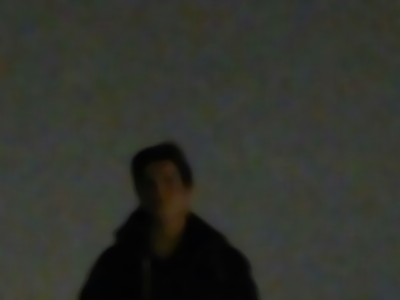

In [46]:
huang_sorted = huang_sort(img_original, 5)
Image.fromarray(huang_sorted)

## Проверка результатов и фактической сложности алгоритмов

In [38]:
img_original = np.array(Image.open('test.jpg'))
R = 13
opencv_median_blur = cv2.medianBlur(img_original, 2 * R + 1)
assert np.allclose(opencv_median_blur, huang_sort(img_original, R))
assert np.allclose(opencv_median_blur, naive_sort(img_original, R))

Оба алгоритма получают такой же результат как и алгоритм medianBlur в opencv.

In [39]:
import time

R_ranged = [3, 5, 7, 9, 10, 15, 30, 50, 70, 99]
naive_time = []
huang_time = []
opencv_time = []

for R in R_ranged:
    # naive
    start_time = time.time()
    naive_sorted = naive_sort(img_original, R)
    end_time = time.time() - start_time
    naive_time.append(end_time)
    
for R in R_ranged:
    # huang
    start_time = time.time()
    huang_sorted = huang_sort(img_original, R)
    end_time = time.time() - start_time
    huang_time.append(end_time)

for R in R_ranged:
    # opencv
    start_time = time.time()
    opencv_median_blur = cv2.medianBlur(img_original, 2 * R + 1)
    end_time = time.time() - start_time
    opencv_time.append(end_time)

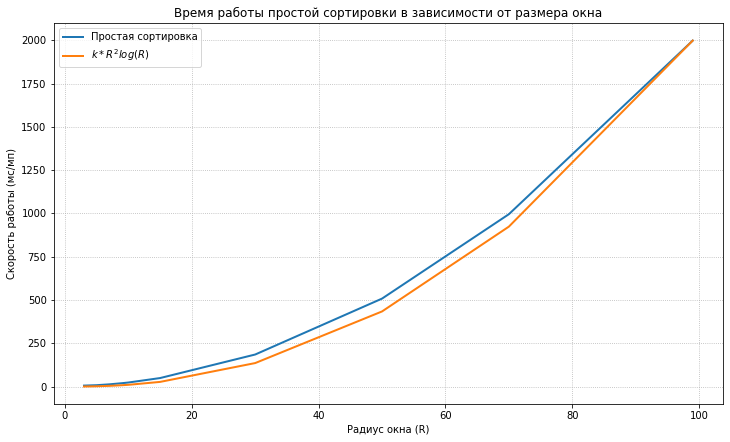

In [40]:
from matplotlib import pyplot as plt

H = img_original.shape[0]
W = img_original.shape[1]

fig, ax = plt.subplots(figsize=(12, 7))

# Простая сортировка
y = [R ** 2 * np.log(R) for i, R in enumerate(R_ranged)]
k = naive_time[-1] / (y[-1] * (H * W /10 ** 6))
ax.plot(R_ranged, [_  / (H * W / 10 ** 6) for _ in naive_time], linewidth=2.0, label='Простая сортировка')
ax.plot(R_ranged, [_ * k for _ in y], linewidth=2.0, label='${k*R^2log(R)}$')

ax.grid(visible=True, which='both', axis='both', linestyle = ':')
plt.title('Время работы простой сортировки в зависимости от размера окна')
plt.xlabel('Радиус окна (R)')
plt.ylabel('Скорость работы (мс/мп)')
plt.legend()
plt.show()

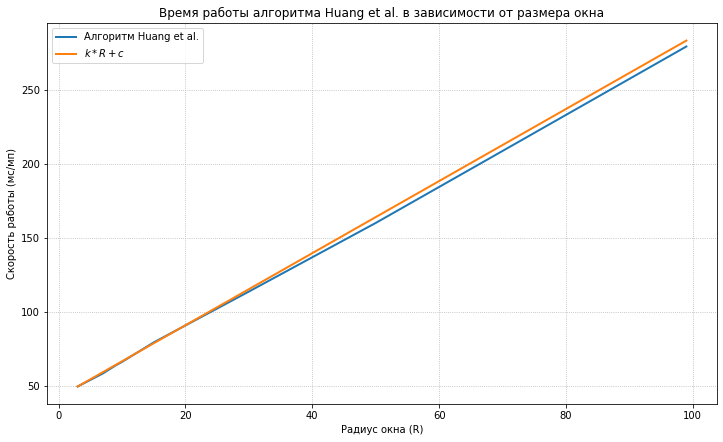

In [47]:
fig, ax = plt.subplots(figsize=(12, 7))

# Алгоритм Huang et al.
k = (huang_time[-1] - huang_time[-2])  / ((R_ranged[-1] - R_ranged[-2]) * (H * W / 10 ** 6))
с = huang_time[0] / (H * W / 10 ** 6) - k * R_ranged[0]
ax.plot(R_ranged, [_  / (H * W /10 ** 6) for _ in huang_time], linewidth=2.0, label='Алгоритм Huang et al.')
ax.plot(R_ranged, [R * k + с for R in R_ranged], linewidth=2.0, label='${k*R+с}$')

ax.grid(visible=True, which='both', axis='both', linestyle = ':')
plt.title('Время работы алгоритма Huang et al. в зависимости от размера окна')
plt.xlabel('Радиус окна (R)')
plt.ylabel('Скорость работы (мс/мп)')
plt.legend()
plt.show()

На графиках видно, что сложности алгоритмов соответствуют заявленным.

## Время работы алгоритмов

In [42]:
print('----------------- Простая сортировка -----------------')
print('---- R ---+--- Время работы (мс) ---+--- Скорость (мс/мп)')
for i, R in enumerate(R_ranged):
    tmp = '    %2.d    |' % (R)
    tmp = tmp + ('     %10.2f          |' % (naive_time[i]))
    tmp = tmp + ('     %10.3f           ' % (naive_time[i] / (H * W /10 ** 6)))
    print(tmp)
print('\n--------------- Алгоритм Huang et al. ---------------')
print('---- R ---+--- Время работы (мс) ---+--- Скорость (мс/мп)')
for i, R in enumerate(R_ranged):
    tmp = '    %2.d    |' % (R)
    tmp = tmp + ('     %10.2f          |' % (huang_time[i]))
    tmp = tmp + ('     %10.3f           ' % (huang_time[i] / (H * W /10 ** 6)))
    print(tmp)
print('\n-------------- Алгоритм opencv.medianBlur --------------')
print('---- R ---+--- Время работы (мс) ---+--- Скорость (мс/мп)')
for i, R in enumerate(R_ranged):
    tmp = '    %2.d    |' % (R)
    tmp = tmp + ('     %10.2f          |' % (opencv_time[i]))
    tmp = tmp + ('     %10.3f           ' % (opencv_time[i] / (H * W /10 ** 6)))
    print(tmp)

----------------- Простая сортировка -----------------
---- R ---+--- Время работы (мс) ---+--- Скорость (мс/мп)
     3    |          18.63          |          5.742           
     5    |          26.27          |          8.096           
     7    |          42.12          |         12.980           
     9    |          63.73          |         19.642           
    10    |          76.16          |         23.472           
    15    |         159.89          |         49.277           
    30    |         601.22          |        185.287           
    50    |        1649.24          |        508.272           
    70    |        3230.82          |        995.690           
    99    |        6485.65          |       1998.783           

--------------- Алгоритм Huang et al. ---------------
---- R ---+--- Время работы (мс) ---+--- Скорость (мс/мп)
     3    |         160.13          |         49.350           
     5    |         174.51          |         53.783           
     7

## Параметры для композиции алгоритмов

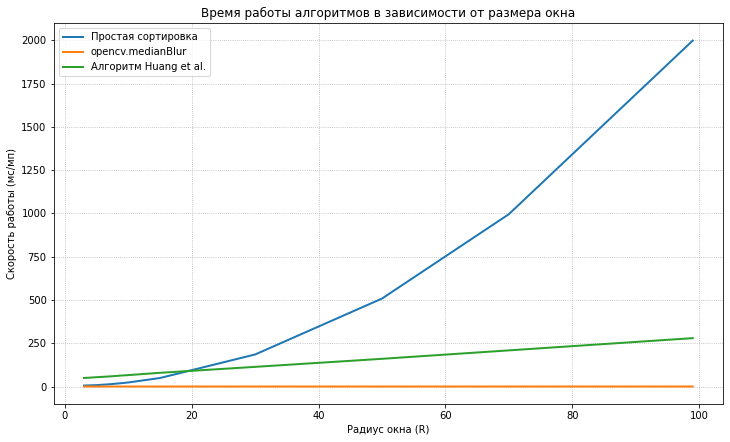

In [48]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(R_ranged, [_  / (H * W /10 ** 6) for _ in naive_time], linewidth=2.0, label='Простая сортировка')
ax.plot(R_ranged, [_  / (H * W /10 ** 6) for _ in opencv_time], linewidth=2.0, label='opencv.medianBlur')
ax.plot(R_ranged, [_  / (H * W /10 ** 6) for _ in huang_time], linewidth=2.0, label='Алгоритм Huang et al.')

ax.grid(visible=True, which='both', axis='both', linestyle = ':')
plt.title('Время работы алгоритмов в зависимости от размера окна')
plt.xlabel('Радиус окна (R)')
plt.ylabel('Скорость работы (мс/мп)')
plt.legend()
plt.show()

По графикам видно, что лучше использовать простую сортировку для ${R<20}$; для ${R\geq20}$ - алгоритм Huang et al.